<h2>Assignment 2 - Logistical Regression</h2>
<h4>Student Name: Kostubh Kumar, 100947773</h4>
<h4>Problem Statement: Create a logistical regression model and the associated ROC/AUC plot of wheat data to predict the risk level</h4>

In [1]:
#Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
#Load dataset
data = pd.read_csv('./WheatData.csv')
data.head()

,A,P,C,LK,WK,A_Coef,LKG,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [4]:
#Key Statistics of Data
data.describe()

,A,P,C,LK,WK,A_Coef,LKG,target
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,1.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,0.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,0.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,1.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,2.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,2.000000


In [5]:
#Checking class balance
print('Class Split')
print(data['target'].value_counts())

Class Split
target
0    70
1    70
2    70
Name: count, dtype: int64


In [6]:
#Create x, y variables 
x = data.drop('target', axis = 1).to_numpy()
y = data['target'].to_numpy()

#Creating the train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 100)

#Scale the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

In [7]:
#Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

name = 'Logistical Regression'
method = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', random_state = 100, max_iter = 1000)
method.fit(x_train_scaled, y_train)
predict = method.predict(x_test_scaled)

print(f'\nEstimator: {name}\n')
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))


Estimator: Logistical Regression

[[12  1  1]
 [ 2 12  0]
 [ 0  0 14]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.92      0.86      0.89        14
           2       0.93      1.00      0.97        14

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.90        42
weighted avg       0.90      0.90      0.90        42



In [8]:
#Create pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = []

pipe_logistic = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(multi_class= 'multinomial', 
                                                                                solver= 'newton-cg',
                                                                                random_state= 100, max_iter= 1000))])
pipeline.insert(0,pipe_logistic)

#Set grid search params
model_para = []
param_gridlogistic = {'clf__C': [0.01, 0.1, 1, 10, 100],
                      'clf__penalty': ['l2'],
                      'clf__solver':['newton-cg', 'sag', 'saga' , 'lbfgs']}
model_para.insert(0, param_gridlogistic)

Logistical Regression Learning Curve


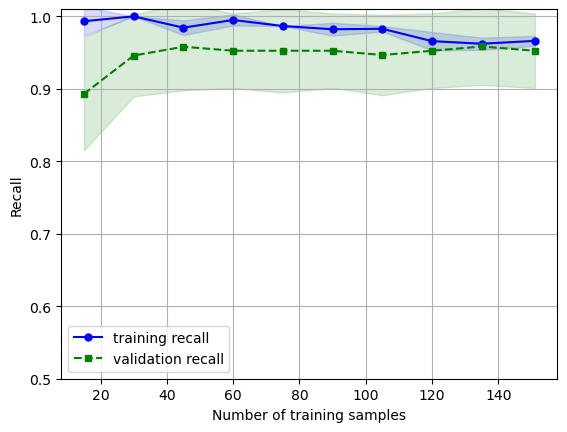

In [9]:
#Defining and Plotting Learning Curve
from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()
    
print('Logistical Regression Learning Curve')
plot_learning_curves(pipe_logistic)

In [10]:
#Define GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['Kama','Rosa','Canadian']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 

In [11]:
#Run Models
for pipeline, modelpara in zip(pipeline,model_para):
    Gridsearch_cv(pipeline,model_para)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 


Optimized Model

Model Name: LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=100,
                   solver='newton-cg')

Best Parameters: {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}

 [[13  1  0]
 [ 1 12  1]
 [ 0  0 14]]

               precision    recall  f1-score   support

        Kama       0.93      0.93      0.93        14
        Rosa       0.92      0.86      0.89        14
    Canadian       0.93      1.00      0.97        14

    accuracy                           0.93        42
   macro avg       0.93      0.93      0.93        42
weighted avg       0.93      0.93      0.93        42



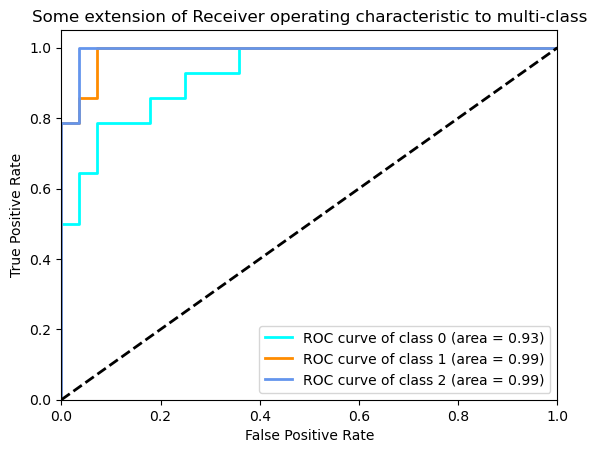

In [12]:
model= LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', random_state = 100, max_iter = 1000)

#Creating Multivariable ROC Curve for original model
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

#Binarize the output
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
le = LabelEncoder()
y2=data['target']
y3= le.fit_transform(y2)
y3 = label_binarize(y3, classes=[0, 1, 2])
x2 = data.drop('target', axis=1).values

#Creating Training and Testing Data
x_train3, x_test3, y_train3, y_test3 = train_test_split(x2, y3, test_size=0.20,stratify=y,random_state=100)
n_classes = y3.shape[1]

#Create ROC Curve
from sklearn.multiclass import OneVsRestClassifier
classOrg = model
classifier = OneVsRestClassifier(model)
y_score = classifier.fit(x_train3, y_train3).predict_proba(x_test3)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test3[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
    
#Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#Plot all ROC curves
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()